In [1]:
import sys
from pathlib import Path

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

Load data

In [4]:
data_dir = Path.cwd().parent.joinpath('data')

In [5]:
mps = {} # mass pairs
mps[1400] = [400, 600, 800, 1000, 1200, 1300]

In [6]:
wr = 1400
n = [400, 600, 800, 1000, 1200, 1300]
eejj_ref = np.load(data_dir.joinpath(f"WR{wr}N{n[0]}_eejjMassArray.npy"))
weight_ref = np.load(data_dir.joinpath(f"WR{wr}N{n[0]}_eejjMassArray.npy"))
x, edges = np.histogram(a=eejj_ref, bins=100, range=[wr*0.45,wr*1.55], density=True)
x = torch.tensor(x, dtype=torch.float32).reshape([1,1,100])

Test 1 conv1D

In [23]:
i = -1
eejj_test = np.load(data_dir.joinpath(f"WR{wr}N{n[i]}_eejjMassArray.npy"))
weight_test = np.load(data_dir.joinpath(f"WR{wr}N{n[i]}_eejjMassArray.npy"))
y, _ = np.histogram(a=eejj_test, bins=100, range=[wr*0.45,wr*1.55], density=True)
y = torch.tensor(y, dtype=torch.float32).reshape([1,1,100])

In [100]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=21, padding=10, bias=False)
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=21, padding=10, bias=False)
#         self.conv3 = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=21, padding=10, bias=False)
#         self.conv4 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=101, padding=50, bias=True)



    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x/torch.sum(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x/torch.sum(x)
#         x = self.conv3(x)
#         x = x/torch.sum(x)
#         x = self.conv4(x)
        
        return x

1109
0.0001632424973649904


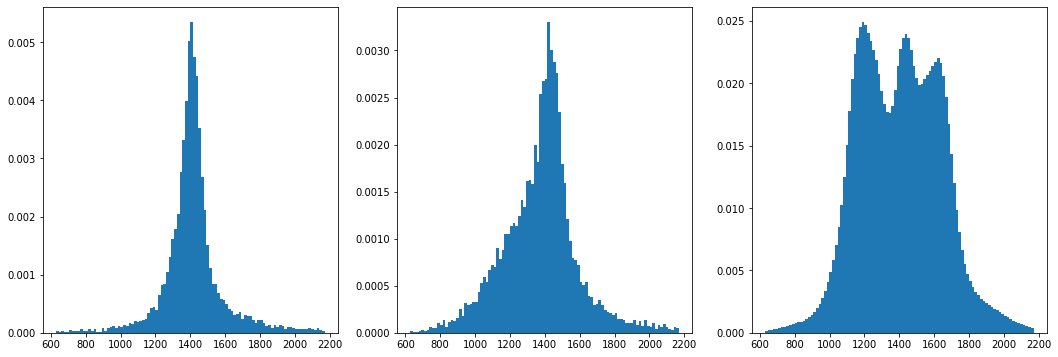

In [112]:
net=model()

import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

best_epoch= 0
lowest_loss = 1000000000.0
for epoch in range(30000):
    p = net(x)
    loss = criterion(p,y)
    
    if loss.item() < lowest_loss:
        lowest_loss = loss.item()
        best_epoch = epoch
        
    if epoch-best_epoch>500:
        break
        
    loss.backward()
    optimizer.step()
    
print(best_epoch)
print(lowest_loss)
    
test=net(x).detach().numpy().reshape(100)
fig, axs = plt.subplots(1,3,figsize=(18,6))
axs[0].bar(x=edges[:-1], height=x.reshape(100).detach().numpy(), width=bar_width, align='edge')
axs[1].bar(x=edges[:-1], height=y.reshape(100).detach().numpy(), width=bar_width, align='edge')
bar_width = edges[1]-edges[0]
axs[2].bar(x=edges[:-1], height=test, width=bar_width, align='edge')
plt.show()